In [18]:
import json
import random
from collections import defaultdict
from rendering_utils import *

## Value Iteration

In [19]:
class QFunction:

    """ Update the Q-value of (state, action) by delta """

    def update(self, state, action, delta):
        pass

    """ Get a Q value for a given state-action pair """

    def get_q_value(self, state, action):
        pass

    """ Save a policy to a specified filename """
    def save_policy(self, filename):
        pass

    """ Load a policy from a specified filename """
    def load_policy(self, filename):
        pass

    """ Return the action with the maximum Q-value """
    def get_argmax_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return argmax_q

    """ Return the maximum Q-value in this Q-function """
    def get_max_q(self, state, actions):
        (argmax_q, max_q) = self.get_max_pair(state, actions)
        return max_q

    """ Return a pair containing the action and Q-value, where the
        action has the maximum Q-value in state
    """
    def get_max_pair(self, state, actions):
        arg_max_q = None
        max_q = float("-inf")
        for action in actions:
            value = self.get_q_value(state, action)
            if max_q < value:
                arg_max_q = action
                max_q = value
        return (arg_max_q, max_q)

In [20]:
class QTable(QFunction):
    def __init__(self, alpha=0.1, default_q_value=0.0):
        self.qtable = defaultdict(lambda: default_q_value)
        self.alpha = alpha

    def update(self, state, action, delta):
        self.qtable[(state, action)] = self.qtable[(state, action)] + self.alpha * delta

    def get_q_value(self, state, action):
        return self.qtable[(state, action)]

    def save(self, filename):
        with open(filename, "w") as file:
            serialised = {str(key): value for key, value in self.qtable.items()}
            json.dump(serialised, file)

    def load(self, filename, default=0.0):
        with open(filename, "r") as file:
            serialised = json.load(file)
            self.qtable = defaultdict(
                lambda: default,
                {tuple(eval(key)): value for key, value in serialised.items()},
            )

In [21]:
class ValueFunction():

    def update(self, state, value):
        pass

    def merge(self, value_table):
        pass

    def get_value(self, state):
        pass

    """ Return the Q-value of action in state """
    def get_q_value(self, mdp, state, action):
        q_value = 0.0
        for (new_state, probability) in mdp.get_transitions(state, action):
            reward = mdp.get_reward(state, action, new_state)
            q_value += probability * (
                reward
                + (mdp.get_discount_factor() * self.get_value(new_state))
            )

        return q_value

In [22]:
class TabularValueFunction(ValueFunction):
    def __init__(self, default=0.0):
        self.value_table = defaultdict(lambda: default)

    def update(self, state, value):
        self.value_table[state] = value

    def merge(self, value_table):
        for state in value_table.value_table.keys():
            self.update(state, value_table.get_value(state))

    def get_value(self, state):
        return self.value_table[state]

In [23]:
class ValueIteration:
    def __init__(self, mdp, values):
        self.mdp = mdp
        self.values = values

    def value_iteration(self, max_iterations=100, theta=0.001):

        for i in range(max_iterations):
            delta = 0.0
            new_values = TabularValueFunction()
            for state in self.mdp.get_states():
                qtable = QTable(alpha=1.0)
                for action in self.mdp.get_actions(state):
                    # Calculate the value of Q(s,a)
                    new_value = 0.0
                    for (new_state, probability) in self.mdp.get_transitions(
                        state, action
                    ):
                        reward = self.mdp.get_reward(state, action, new_state)
                        new_value += probability * (
                            reward
                            + (
                                self.mdp.get_discount_factor()
                                * self.values.get_value(new_state)
                            )
                        )

                    qtable.update(state, action, new_value)

                # V(s) = max_a Q(sa)
                max_q = qtable.get_max_q(state, self.mdp.get_actions(state))
                delta = max(delta, abs(self.values.get_value(state) - max_q))
                new_values.update(state, max_q)

            self.values.merge(new_values)

            # Terminate if the value function has converged
            if delta < theta:
                return i

## Value Iteration for GridWorld

![GridWorld](./images/grid_world.png)

#### Bandit

In [24]:
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        pass

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()

In [25]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        arg_max_q = qfunction.get_argmax_q(state, actions)
        return arg_max_q

#### Policy

In [26]:
class Policy:
    def select_action(self, state, action):
        pass


class DeterministicPolicy(Policy):
    def update(self, state, action):
        pass
    

class StochasticPolicy(Policy):
    def update(self, states, actions, rewards):
        pass


class ValuePolicy(DeterministicPolicy):
    def __init__(self, mdp, values):
        self.mdp = mdp
        self.values = values

    def select_action(self, state, actions):
        qfunction = QTable()
        for action in actions:
            q_value = self.values.get_q_value(self.mdp, state, action)
            qfunction.update(state, action, q_value)
        return qfunction.get_argmax_q(state, actions)
    

class StochasticValuePolicy(StochasticPolicy):
    def __init__(self, mdp, values, bandit=EpsilonGreedy(epsilon=.05)):
        self.mdp = mdp
        self.values = values
        self.bandit = bandit

    def select_action(self, state, actions):
        qfunction = QTable()
        for action in actions:
            q_value = self.values.get_q_value(self.mdp, state, action)
            qfunction.update(state, action, q_value)
        return self.bandit.select(state, actions, qfunction)

#### Environment

In [63]:
class MDP:
    """Return all states of this MDP"""

    def get_states(self):
        pass

    """ Return all actions with non-zero probability from this state """

    def get_actions(self, state):
        pass

    """ Return all non-zero probability transitions for this action
        from this state, as a list of (state, probability) pairs
    """

    def get_transitions(self, state, action):
        pass

    """ Return the reward for transitioning from state to
        nextState via action
    """

    def get_reward(self, state, action, next_state):
        pass

    """ Return true if and only if state is a terminal state of this MDP """

    def is_terminal(self, state):
        pass

    """ Return the discount factor for this MDP """

    def get_discount_factor(self):
        pass

    """ Return the initial state of this MDP """

    def get_initial_state(self):
        pass

    """ Return all goal states of this MDP """

    def get_goal_states(self):
        pass

    """ Return a new state and a reward for executing action in state,
    based on the underlying probability. This can be used for
    model-free learning methods, but requires a model to operate.
    Override for simulation-based learning
    """

    def execute(self, state, action):
        rand = random.random()
        cumulative_probability = 0.0
        for (new_state, probability) in self.get_transitions(state, action):
            if cumulative_probability <= rand <= probability + cumulative_probability:
                reward = self.get_reward(state, action, new_state)
                return (new_state, reward, self.is_terminal(new_state))
            cumulative_probability += probability
            if cumulative_probability >= 1.0:
                raise (
                    "Cumulative probability >= 1.0 for action "
                    + str(action)
                    + " from "
                    + str(state)
                )

        raise BaseException(
            "No outcome state in simulation for action "
            + str(action)
            + " from "
            + str(state)
        )

    """ 
    Execute a policy on this mdp for a number of episodes.
    """

    def execute_policy(self, policy, episodes=100, max_step=100):
        cumulative_rewards = []
        states = set()
        for _ in range(episodes):
            cumulative_reward = 0.0
            state = self.get_initial_state()
            step = 0
            while not self.is_terminal(state):
                actions = self.get_actions(state)
                action = policy.select_action(state, actions)
                (next_state, reward, done) = self.execute(state, action)
                cumulative_reward += reward * (self.discount_factor ** step)
                state = next_state
                step += 1
                if step > max_step:
                    break
            cumulative_rewards += [cumulative_reward]
        return cumulative_rewards

In [64]:
class GridWorld(MDP):
    # labels for terminate action and terminal state
    TERMINAL = (-1, -1)
    TERMINATE = 0
    LEFT = 1
    UP = 2
    RIGHT = 3
    DOWN = 4

    def __init__(
        self,
        noise=0.1,
        width=4,
        height=3,
        discount_factor=0.9,
        blocked_states=[(1, 1)],
        action_cost=0.0,
        initial_state=(0, 0),
        goals=None,
    ):
        self.noise = noise
        self.width = width
        self.height = height
        self.blocked_states = blocked_states
        self.discount_factor = discount_factor
        self.action_cost = action_cost
        self.initial_state = initial_state
        if goals is None:
            self.goal_states = dict(
                [((width - 1, height - 1), 1), ((width - 1, height - 2), -1)]
            )
        else:
            self.goal_states = dict(goals)

        # A list of lists that records all rewards given at each step
        # for each episode of a simulated gridworld
        self.rewards = []

        # A list of cumulative rewards for each episode
        self.cumulative_rewards = []
    
        # The rewards for the current episode
        self.episode_rewards = []


    def get_states(self):
        states = [self.TERMINAL]
        for x in range(self.width):
            for y in range(self.height):
                if not (x, y) in self.blocked_states:
                    states.append((x, y))
        return states

    def get_actions(self, state=None):

        actions = [self.TERMINATE, self.LEFT, self.UP, self.RIGHT, self.DOWN]
        if state is None:
            return actions

        valid_actions = []
        for action in actions:
            for (new_state, probability) in self.get_transitions(state, action):
                if probability > 0:
                    valid_actions.append(action)
                    break
        return valid_actions

    def get_initial_state(self):
        self.episode_rewards = []
        return self.initial_state

    def get_goal_states(self):
        return self.goal_states

    def valid_add(self, state, new_state, probability):
        # If the next state is blocked, stay in the same state
        if probability == 0.0:
            return []

        if new_state in self.blocked_states:
            return [(state, probability)]

        # Move to the next space if it is not off the grid
        (x, y) = new_state
        if x >= 0 and x < self.width and y >= 0 and y < self.height:
            return [((x, y), probability)]

        # If off the grid, state in the same state
        return [(state, probability)]

    def get_transitions(self, state, action):
        transitions = []

        if state == self.TERMINAL:
            if action == self.TERMINATE:
                return [(self.TERMINAL, 1.0)]
            else:
                return []

        # Probability of not slipping left or right
        straight = 1 - (2 * self.noise)

        (x, y) = state
        if state in self.get_goal_states().keys():
            if action == self.TERMINATE:
                transitions += [(self.TERMINAL, 1.0)]

        elif action == self.UP:
            transitions += self.valid_add(state, (x, y + 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.DOWN:
            transitions += self.valid_add(state, (x, y - 1), straight)
            transitions += self.valid_add(state, (x - 1, y), self.noise)
            transitions += self.valid_add(state, (x + 1, y), self.noise)

        elif action == self.RIGHT:
            transitions += self.valid_add(state, (x + 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        elif action == self.LEFT:
            transitions += self.valid_add(state, (x - 1, y), straight)
            transitions += self.valid_add(state, (x, y - 1), self.noise)
            transitions += self.valid_add(state, (x, y + 1), self.noise)

        # Merge any duplicate outcomes
        merged = defaultdict(lambda: 0.0)
        for (state, probability) in transitions:
            merged[state] = merged[state] + probability

        transitions = []
        for outcome in merged.keys():
            transitions += [(outcome, merged[outcome])]

        return transitions

    def get_reward(self, state, action, new_state):
        reward = 0.0
        if state in self.get_goal_states().keys() and new_state == self.TERMINAL:
            reward = self.get_goal_states().get(state)
        else:
            reward = self.action_cost
        step = len(self.episode_rewards)
        self.episode_rewards += [reward * (self.discount_factor ** step)]
        return reward

    def get_discount_factor(self):
        return self.discount_factor

    def is_terminal(self, state):
        if state == self.TERMINAL:
            return True
        return False

    """
        Returns a list of lists, which records all rewards given at each step
        for each episode of a simulated gridworld
    """

    def get_rewards(self):
        return self.rewards
    

    """
        Returns a list of all cumulative rewards
        for each episode of a simulated gridworld
    """

    def get_cumulative_rewards(self):
        return self.cumulative_rewards

    """
        Create a gridworld from an array of strings: one for each line
        - First line is rewards as a dictionary from cell to value: {'A': 1, ...}
        - space is an empty cell
        - # is a blocked cell
        - @ is the agent (initial state)
        - new 'line' is a new row
        - a letter is a cell with a reward for transitioning
          into that cell. The reward defined by the first line.
    """

    @staticmethod
    def create(string):
        # Parse the reward on the first line
        import ast

        rewards = ast.literal_eval(string[0])

        width = 0
        height = len(string) - 1

        blocked_cells = []
        initial_state = (0, 0)
        goals = []
        row = 0
        for next_row in string[1:]:
            column = 0
            for cell in next_row:
                if cell == "#":
                    blocked_cells += [(column, row)]
                elif cell == "@":
                    initial_state = (column, row)
                elif cell.isalpha():
                    goals += [((column, row), rewards[cell])]
                column += 1
            width = max(width, column)
            row += 1
        return GridWorld(
            width=width,
            height=height,
            blocked_states=blocked_cells,
            initial_state=initial_state,
            goals=goals,
        )

    @staticmethod
    def open(file):
        file = open(file, "r")
        string = file.read().splitlines()
        file.close()
        return GridWorld.create(string)

    @staticmethod
    def matplotlib_installed():
        try:
            import matplotlib as mpl
            import matplotlib.pyplot as plt
            return True
        except ModuleNotFoundError:
            return False

    """ Visualise a Grid World problem """

    def visualise(self, agent_position=None, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_as_image(agent_position=agent_position, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.to_string(title=title))

    """ Visualise a Grid World value function """
    def visualise_value_function(self, value_function, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_value_function_as_image(value_function, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.value_function_to_string(value_function, title=title))

    def visualise_q_function(self, qfunction, title="", grid_size=1.5, gif=False):
        if self.matplotlib_installed():
            return self.visualise_q_function_as_image(qfunction, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.q_function_to_string(qfunction, title=title))

    def visualise_policy(self, policy, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            print(self.policy_to_string(policy, title=title))

    def visualise_stochastic_policy(self, policy, title="", grid_size=1.0, gif=False):
        if self.matplotlib_installed():
            return self.visualise_stochastic_policy_as_image(policy, title=title, grid_size=grid_size, gif=gif)
        else:
            # TODO make a stochastic policy to string
            pass

    """ Visualise a grid world problem as a formatted string """
    def to_string(self, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"


        space = " |              "
        block = " | #############"

        line = "  "
        for x in range(self.width):
            line += "--------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     _____    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||o  o|   "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " | {}  ||  * |  {}".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}    ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}           {}".format(left_arrow, right_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |    ||====|   ".format(left_arrow, right_arrow)
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) == self.get_initial_state():
                    result += " |     -----    "
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.get_goal_states().keys():
                    result += space
                elif (x, y) in self.blocked_states:
                    result += block
                else:
                    result += " |       {}      ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world value function to a formatted string """

    def value_function_to_string(self, values, title=""):
        line = " {:-^{n}}\n".format("", n=len(" | +0.00") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | #####"
                else:
                    result += " | {:+0.2f}".format(values.get_value((x, y)))
            result += " |\n"
            result += line

        return result

    """ Convert a grid world Q function to a formatted string """

    def q_function_to_string(self, qfunction, title=""):
        left_arrow = "\u25C4"
        up_arrow = "\u25B2"
        right_arrow = "\u25BA"
        down_arrow = "\u25BC"

        space = " |               "

        line = "  "
        for x in range(self.width):
            line += "---------------- "
        line += "\n"

        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(up_arrow)
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get_q_value((x, y), self.UP)
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " |     #####     "
                elif (x, y) in self.get_goal_states().keys():
                    result += " |     {:+0.2f}     ".format(
                        self.get_goal_states()[(x, y)]
                    )
                else:
                    result += " | {}{:+0.2f}  {:+0.2f}{}".format(
                        left_arrow,
                        qfunction.get_q_value((x, y), self.LEFT),
                        qfunction.get_q_value((x, y), self.RIGHT),
                        right_arrow,
                    )
            result += " |\n"

            for x in range(self.width):
                result += space
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |     {:+0.2f}     ".format(
                        qfunction.get_q_value((x, y), self.DOWN)
                    )
            result += " |\n"

            for x in range(self.width):
                if (x, y) in self.blocked_states or (
                    x,
                    y,
                ) in self.get_goal_states().keys():
                    result += space
                else:
                    result += " |       {}       ".format(down_arrow)
            result += " |\n"
            result += line
        return result

    """ Convert a grid world policy to a formatted string """
    def policy_to_string(self, policy, title=""):
        arrow_map = {self.UP:'\u25B2',
                     self.DOWN:'\u25BC',
                     self.LEFT:'\u25C4',
                     self.RIGHT:'\u25BA',
                    }
        line = " {:-^{n}}\n".format("", n=len(" |  N ") * self.width + 1)
        result = " " + title + "\n"
        result += line
        for y in range(self.height - 1, -1, -1):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    result += " | ###"
                elif policy.select_action((x, y), self.get_actions((x, y))) == self.TERMINATE:
                    result += " | {:+0d} ".format(self.goal_states[(x, y)])
                else:
                    result += " |  " + arrow_map[policy.select_action((x, y), self.get_actions((x, y)))] + " "
            result += " |\n"
            result += line

        return result


    """ Initialise a gridworld grid """
    def initialise_grid(self, grid_size=1.0):
        fig = plt.figure(figsize=(self.width * grid_size, self.height * grid_size))

        # Trim whitespace 
        plt.subplots_adjust(top=0.92, bottom=0.01, right=1, left=0, hspace=0, wspace=0)
        ax = fig.add_subplot(1, 1, 1)

        # Initialise the map to all white
        img = [[COLOURS['white'] for _ in range(self.width)] for _ in range(self.height)]

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) in self.goal_states:
                    img[y][x] = COLOURS['red'] if self.goal_states[(x, y)] < 0 else COLOURS['green']
                elif (x, y) in self.blocked_states:
                    img[y][x] = COLOURS['grey']

        ax.xaxis.set_ticklabels([])  # clear x tick labels
        ax.axes.yaxis.set_ticklabels([])  # clear y tick labels
        ax.tick_params(which='both', top=False, left=False, right=False, bottom=False)
        ax.set_xticks([w - 0.5 for w in range(0, self.width, 1)])
        ax.set_yticks([h - 0.5 for h in range(0, self.height, 1)])
        ax.grid(color='lightgrey')
        return fig, ax, img

    """ visualise the gridworld problem as a matplotlib image """

    def visualise_as_image(self, agent_position=None, title="", grid_size=1.0, gif=False):
        fig, ax, img = self.initialise_grid(grid_size=grid_size)
        current_position = (
            self.get_initial_state() if agent_position is None else agent_position
        )

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                if (x, y) == current_position:
                    ax.scatter(x, y, s=2000, marker='o', edgecolors='none')
                elif (x, y) in self.goal_states:
                    plt.text(
                        x,
                        y,
                        f"{self.get_goal_states()[(x, y)]:+0.2f}",
                        fontsize="x-large",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        im = plt.imshow(img, origin="lower")
        plt.title(title)
        if gif:
            return fig, ax, im
        else:
            return fig

    """Render each tile individually depending on the current state of the cell"""

    def render_tile(self, x, y, tile_size, img, tile_type=None):
        ymin = y * tile_size
        ymax = (y + 1) * tile_size
        xmin = x * tile_size
        xmax = (x + 1) * tile_size

        for i in range(ymin, ymax):
            for j in range(xmin, xmax):
                if i == ymin or i == ymax - 1 or j == xmin or j == xmax + 1:
                    draw_grid_lines(i, j, img)
                else:
                    if tile_type == "goal":
                        render_goal(
                            i,
                            j,
                            img,
                            reward=self.goal_states[(x, y)],
                            reward_max=max(self.get_goal_states().values()),
                            reward_min=min(self.get_goal_states().values()),
                        )
                    elif tile_type == "blocked":
                        render_blocked_tile(i, j, img)
                    elif tile_type == "agent":
                        render_agent(
                            i,
                            j,
                            img,
                            center_x=xmin + tile_size / 2,
                            center_y=ymin + tile_size / 2,
                            radius=tile_size / 4,
                        )
                    elif tile_type == "empty":
                        img[i][j] = [255, 255, 255]
                    else:
                        raise ValueError("Invalid tile type")

    """ Visualise the value function """

    def visualise_value_function_as_image(self, value_function, title="", grid_size=1.0, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                value = value_function.get_value((x, y))
                if (x, y) not in self.blocked_states:
                    text = plt.text(
                        x,
                        y,
                        f"{float(value):+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="center",
                        color='lightgrey' if value == 0.0 else 'black',
                    )
                    texts.append(text)
        if gif:
            return texts
        else:
            ax.imshow(img, origin="lower")
            plt.title(title, fontsize="large")
            plt.show()

    """ Visualise the value function using a heat-map where green is high value and
    red is low value
    """

    def visualise_value_function_as_heatmap(self, value_function, title=""):
        values = [[0 for _ in range(self.width)] for _ in range(self.height)]
        fig, ax = self.initialise_grid()
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.blocked_states:
                    plt.text(
                        x,
                        y,
                        "#",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
                else:
                    values[y][x] = value_function.get_value((x, y))
                    plt.text(
                        x,
                        y,
                        f"{values[y][x]:.2f}",
                        horizontalalignment="center",
                        verticalalignment="center",
                    )
        plt.imshow(values, origin="lower", cmap=make_red_white_green_cmap())
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with matplotlib """

    def visualise_q_function_as_image(self, qfunction, title="", grid_size=1.5, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x,y)]:+0.2f}",
                            fontsize="large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                elif (x, y) not in self.blocked_states:
                    up_value = qfunction.get_q_value((x, y), self.UP)
                    down_value = qfunction.get_q_value((x, y), self.DOWN)
                    left_value = qfunction.get_q_value((x, y), self.LEFT)
                    right_value = qfunction.get_q_value((x, y), self.RIGHT)
                    texts.append(plt.text(
                        x,
                        y + 0.35,
                        f"{up_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="top",
                        color='lightgrey' if up_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x,
                        y - 0.35,
                        f"{down_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="center",
                        verticalalignment="bottom",
                        color='lightgrey' if down_value == 0.0 else 'black',
                    ))
                    texts.append(plt.text(
                        x - 0.45,
                        y,
                        f"{left_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="left",
                        verticalalignment="center",
                        color='lightgrey' if left_value == 0.0 else 'black'
                    ))
                    texts.append(plt.text(
                        x + 0.45,
                        y,
                        f"{right_value:+0.2f}",
                        fontsize="medium",
                        horizontalalignment="right",
                        verticalalignment="center",
                        color='lightgrey' if right_value == 0.0 else 'black'
                    ))
                    plt.plot([x-0.5, x+0.5], [y-0.5, y+0.5], ls='-', lw=1, color='lightgrey')
                    plt.plot([x + 0.5, x - 0.5], [y - 0.5, y + 0.5], ls='-', lw=1, color='lightgrey')
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    """ Visualise the Q-function with a matplotlib visual"""

    def visualise_q_function_rendered(self, q_values, title="", tile_size=32, show_text=False):
        width_px = self.width * tile_size
        height_px = self.height * tile_size
        img = [[[0, 0, 0] for _ in range(width_px)] for _ in range(height_px)]

        # provide these to scale the colours between the highest and lowest value
        reward_max = max(self.get_goal_states().values())
        reward_min = min(self.get_goal_states().values())
        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                # Draw in the blocked states as a black and white mesh
                if (x, y) in self.blocked_states:
                    render_full_blocked_tile(
                        x * tile_size, y * tile_size, tile_size, img
                    )
                    continue
                # Draw goal states
                if (x, y) in self.goal_states:
                    render_full_goal_tile(
                        x * tile_size,
                        y * tile_size,
                        tile_size,
                        img,
                        reward=self.goal_states[(x, y)],
                        rewardMax=reward_max,
                        rewardMin=reward_min,
                    )
                    continue

                # Draw the action value for action available in each cell
                # Break the grid up into 4 sections, using triangles that meet
                # in the middle. The base of the triangle points toward the
                # direction of the action
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.UP,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.DOWN,
                    q_values,
                    img,
                    show_text,
                    v_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.LEFT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=-8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )
                render_action_q_value(
                    tile_size,
                    x,
                    y,
                    self.RIGHT,
                    q_values,
                    img,
                    show_text,
                    h_text_offset=8,
                    rewardMax=reward_max,
                    rewardMin=reward_min,
                )

        ax.imshow(img, origin="lower", interpolation="bilinear")
        plt.title(title)
        plt.axis("off")
        plt.show()

    """ Visualise the policy of the agent with a matplotlib visual """

    def visualise_policy_as_image(self, policy, title="", grid_size=1.0, gif=False):
        # Map from action names to prettier arrows
        arrow_map = {self.UP:'\u2191',
                     self.DOWN:'\u2193',
                     self.LEFT:'\u2190',
                     self.RIGHT:'\u2192',
                    }
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []
        for y in range(self.height):
            for x in range(self.width):
                if (x, y) not in self.blocked_states and (x, y) not in self.goal_states:
                    if policy.select_action((x, y), self.get_actions((x, y))) != self.TERMINATE:
                        action = arrow_map[policy.select_action((x, y), self.get_actions((x, y)))]
                        fontsize = "xx-large"
                    texts.append(plt.text(
                                x,
                                y,
                                action,
                                fontsize=fontsize,
                                horizontalalignment="center",
                                verticalalignment="center",
                            ))
                elif (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()

    def execute(self, state, action):
        if state in self.goal_states:
            self.rewards += [self.episode_rewards]
            self.cumulative_rewards += [sum(self.episode_rewards)]
            return MDP.execute(self, state=state, action=self.TERMINATE)
        return super().execute(state, action)

    def visualise_stochastic_policy_as_image(self, policy, title="", grid_size=1.0, gif=False):
        if not gif:
            fig, ax, img = self.initialise_grid(grid_size=grid_size)
        texts = []

        # Render the grid
        for y in range(0, self.height):
            for x in range(0, self.width):
                prob_up = 0.0
                prob_down = 0.0
                prob_left = policy.get_probability((x, y), self.LEFT)
                prob_right = policy.get_probability((x, y), self.RIGHT)
                if self.height > 1:
                    prob_up = policy.get_probability((x, y), self.UP)
                    prob_down = policy.get_probability((x, y), self.DOWN)
                # Normalise to account for the 'terminate' action that is not visualised
                total = prob_left + prob_right + prob_down + prob_up
                if total != 0:
                    prob_left = prob_left / total
                    prob_right = prob_right / total
                    prob_down = prob_down / total
                    prob_up = prob_up / total
                if (x, y) in self.goal_states:
                    # gif player handles goal state rendering
                    if not gif:
                        plt.text(
                            x,
                            y,
                            f"{self.get_goal_states()[(x, y)]:+0.2f}",
                            fontsize="x-large",
                            horizontalalignment="center",
                            verticalalignment="center",
                        )
                elif (x, y) not in self.blocked_states:
                    left_triangle = '\u25C4'
                    up_triangle = '\u25B2'
                    right_triangle = '\u25BA'
                    down_triangle = '\u25BC'
                    if self.height > 1:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_up:0.2f}\n{up_triangle}\n{prob_left:0.2f}{left_triangle} {right_triangle}{prob_right:0.2f}\n{down_triangle}\n{prob_down:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
                    else:
                        texts.append(plt.text(
                            x,
                            y,
                            f"{prob_left:0.2f}{left_triangle} {right_triangle}{prob_right:0.2f}",
                            fontsize="medium",
                            horizontalalignment="center",
                            verticalalignment="center",
                        ))
        if gif:
            return texts
        ax.imshow(img, origin="lower")
        plt.title(title)
        plt.show()
        return fig

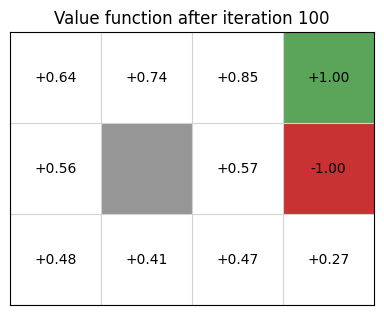

In [65]:
gridworld = GridWorld()
values = TabularValueFunction()
ValueIteration(gridworld, values).value_iteration(max_iterations=10)
gridworld.visualise_value_function(values, "Value function after iteration 100")

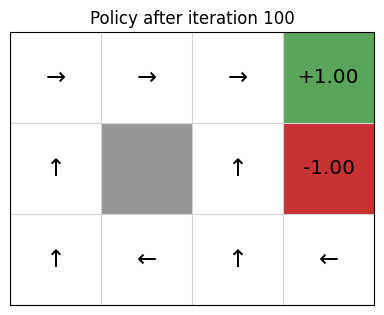

In [66]:
policy = ValuePolicy(gridworld, values)
gridworld.visualise_policy(policy, "Policy after iteration 100")

## Evaluating Policies

In [ ]:
from plot import Plot

In [70]:
gridworld = GridWorld()
values = TabularValueFunction()
policy = ValuePolicy(gridworld, values)
rewards = gridworld.execute_policy(policy, episodes=1)
for _ in range(50):
    ValueIteration(gridworld, values).value_iteration(max_iterations=1)
    policy = ValuePolicy(gridworld, values)
    rewards += gridworld.execute_policy(policy, episodes=1)

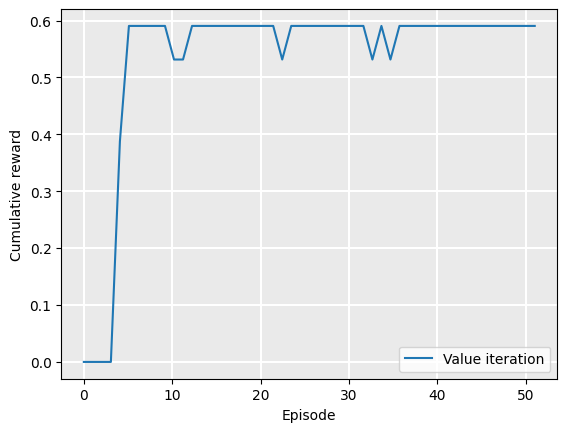

In [74]:
Plot.plot_cumulative_rewards(["Value iteration"], [rewards], smoothing_factor=0.0)

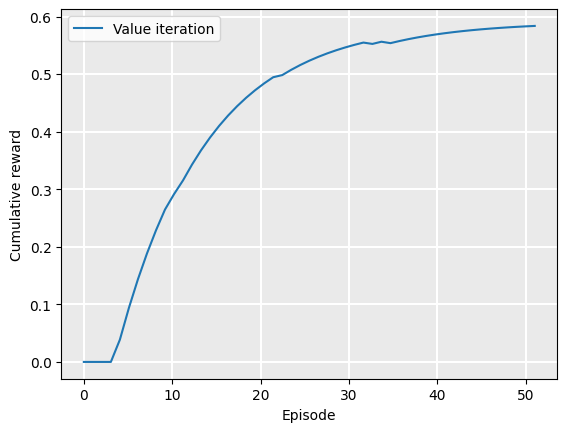

In [75]:
Plot.plot_cumulative_rewards(["Value iteration"], [rewards], smoothing_factor=0.9)

In [76]:
values = TabularValueFunction()
gridworld = GridWorld(noise=0.0)
policy = StochasticValuePolicy(gridworld, values)
rewards = gridworld.execute_policy(policy, episodes=1)
for _ in range(50):
    ValueIteration(gridworld, values).value_iteration(max_iterations=1)
    policy = StochasticValuePolicy(gridworld, values)
    rewards += gridworld.execute_policy(policy, episodes=1)

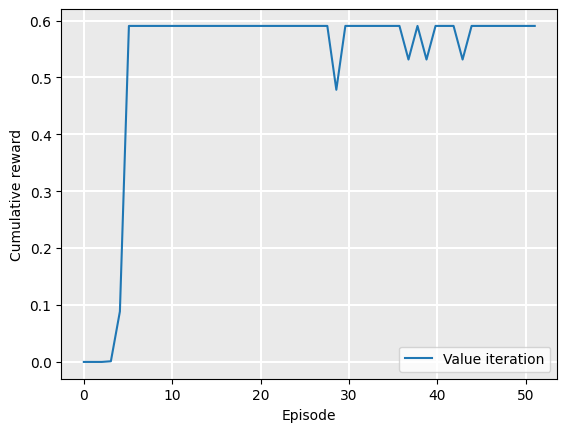

In [77]:
Plot.plot_cumulative_rewards(["Value iteration"], [rewards], smoothing_factor=0.0)

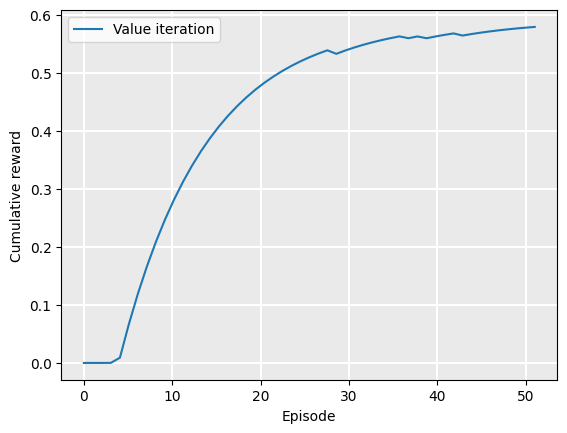

In [78]:
Plot.plot_cumulative_rewards(["Value iteration"], [rewards], smoothing_factor=0.9)

## Further Examples

#### Value Iteration for Maze Solving

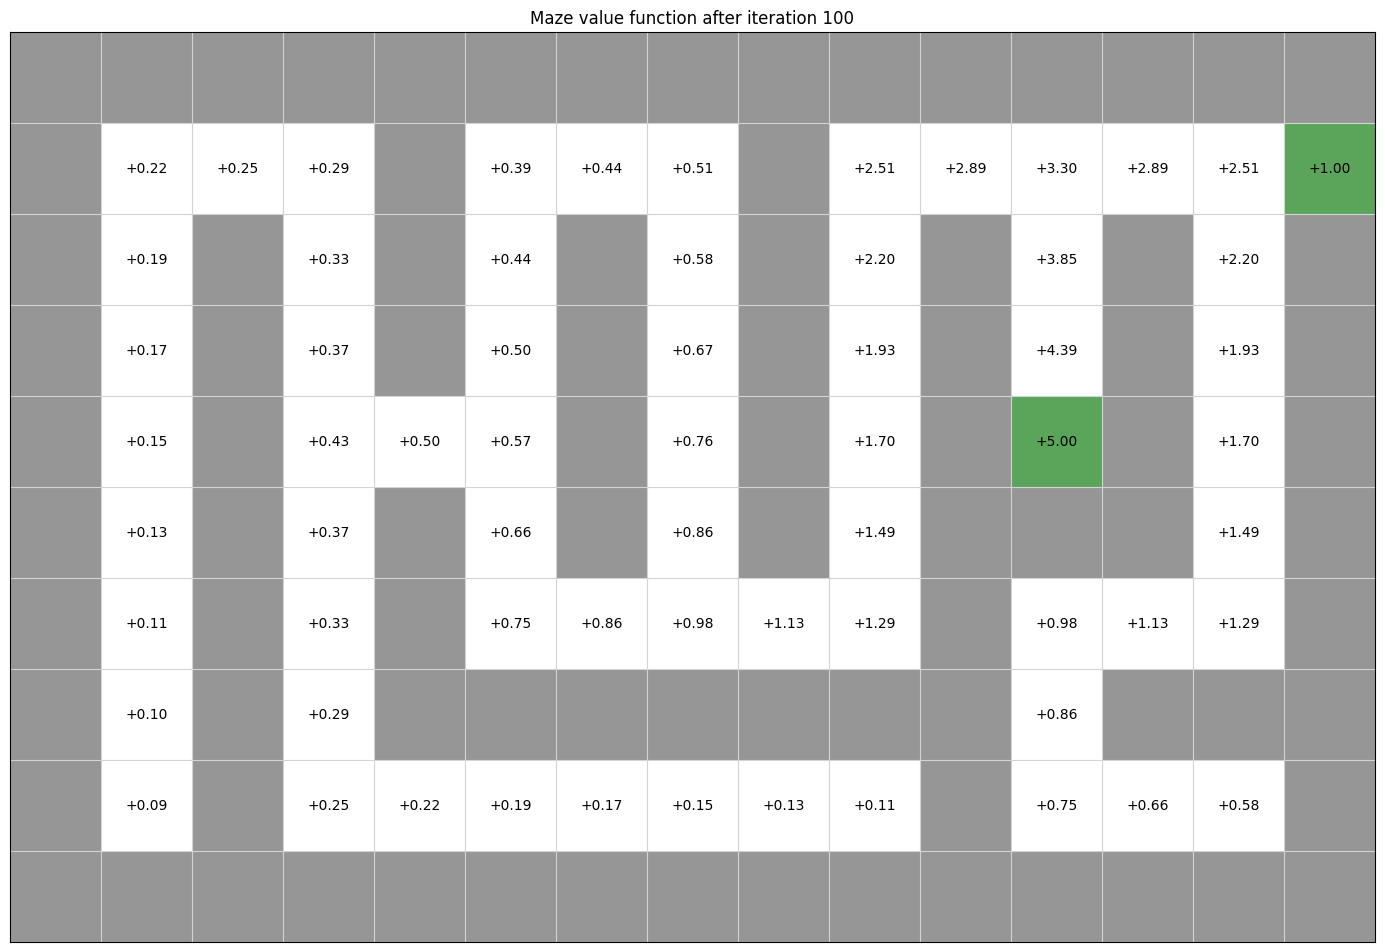

In [82]:
maze = GridWorld.open('./python_code/layouts/maze.txt')
values = TabularValueFunction()
ValueIteration(maze, values).value_iteration(max_iterations=100)
maze.visualise_value_function(values, "Maze value function after iteration 100")

#### Value Iteration in Contested Crossing

In [86]:
import numpy as np


SUNK_REWARD = -10
BERTH_REWARD = 10

# six directions for movement - W, NW, NE, E, SE, SW - and can shoot
W = 0
NW = 1
NE = 2
E = 3
SE = 4
SW = 5
SHOOT = 6

# region types
SHORE1 = 10
SHORE2 = 11
LAND = 12
SEA = 13
# danger zones
HI_DGR = 3
LO_DGR = 4
NO_DGR = 5

DEFAULT_REGIONS = {
    (2, 0): SHORE2,
    (3, 0): LAND,
    (4, 0): LAND,
    (5, 0): LAND,
    (2, 1): SHORE2,
    (3, 1): LAND,
    (4, 1): LAND,
    (3, 2): SHORE2,
    (4, 2): LAND,
    (5, 2): LAND,
    (3, 3): SHORE2,
    (4, 3): SHORE2,
    (3, 5): SHORE1,
    (4, 5): SHORE1,
    (3, 6): SHORE1,
    (4, 6): LAND,
    (5, 6): LAND,
    (2, 7): SHORE1,
    (3, 7): LAND,
    (4, 7): LAND,
    (2, 8): SHORE1,
    (3, 8): LAND,
    (4, 8): LAND,
    (5, 8): LAND,
    (1, 9): SHORE1,
    (2, 9): LAND,
    (3, 9): LAND,
    (4, 9): LAND,
    (5, 9): LAND,
}

DEFAULT_DANGER = {
    (1, 1): LO_DGR,
    (2, 1): LO_DGR,
    (1, 2): LO_DGR,
    (2, 2): LO_DGR,
    (3, 2): HI_DGR,
    (1, 3): LO_DGR,
    (2, 3): HI_DGR,
    (3, 3): HI_DGR,
    (4, 3): HI_DGR,
    (1, 4): LO_DGR,
    (2, 4): HI_DGR,
    (3, 4): HI_DGR,
    (4, 4): HI_DGR,
    (1, 5): LO_DGR,
    (2, 5): HI_DGR,
    (3, 5): HI_DGR,
    (4, 5): HI_DGR,
    (1, 6): LO_DGR,
    (2, 6): LO_DGR,
    (3, 6): HI_DGR,
    (1, 7): LO_DGR,
    (2, 7): LO_DGR,
    (2, 8): LO_DGR,
}
DEFAULT_WIDTH = 5
DEFAULT_HEIGHT = 10
DEFAULT_BATTERY = (3, 3)
DEFAULT_SHIP = (2, 8)
REGION_COLOURS = {
    SHORE1: "#876445",
    SHORE2: "#876445",
    LAND: "#EDDFB3",
    SEA: "#EFEFEF",
    HI_DGR: "#ff0000",
    LO_DGR: "#ff8800",
    NO_DGR: "#FFFFFF",
    -1: "#FFFFFF",
}
SHIP_COLOR = "#4466aa"
BATTERY_COLOR = "#441111"
SHIP_SYMBOL = "\u03e1"
BATTERY_SYMBOL = "\u273A"


left_cell = lambda o: (o[0] - 1, o[1])
right_cell = lambda o: (o[0] + 1, o[1])
down_left_cell = lambda o: (o[0] + (o[1] % 2) - 1, o[1] + 1)
down_right_cell = lambda o: (o[0] + (o[1] % 2), o[1] + 1)
up_left_cell = lambda o: (o[0] + (o[1] % 2) - 1, o[1] - 1)
up_right_cell = lambda o: (o[0] + (o[1] % 2), o[1] - 1)


class ContestedCrossing(MDP):
    # labels for actions and states
    TERMINATE = "terminate"
    TERMINAL = ("terminal", "terminal", "terminal", "terminal", "terminal")

    # state of the single-agent game is given by 5 integers:
    # xpos, ypos, ship_damage, battery1_damage, battery2_damage

    def __init__(
        self,
        high_danger=0.9,
        low_danger=0.1,
        battery_health=2,
        ship_health=3,
        discount_factor=0.9,
        action_cost=0.0,
        width=DEFAULT_WIDTH,
        height=DEFAULT_HEIGHT,
        regions=DEFAULT_REGIONS,
        danger=DEFAULT_DANGER,
        battery=DEFAULT_BATTERY,
        ship=DEFAULT_SHIP,
    ):
        self.width = width
        self.height = height
        self.regions = defaultdict(lambda: SEA, regions)
        self.terrain = self._make_terrain(self.regions)
        self.danger_zones = defaultdict(lambda: NO_DGR, danger)
        self.battery = battery
        self.ship = ship
        self.high_danger = high_danger
        self.low_danger = low_danger
        self.battery_full_health = battery_health
        self.ship_full_health = ship_health
        self.battery_health = battery_health
        self.ship_health = ship_health
        self.discount_factor = discount_factor
        self.action_cost = action_cost
        self.initial_state = (
            self.ship[0],
            self.ship[1],
            ship_health,
            battery_health,
            W,
        )
        self.blocks = self._make_block_dict(self.regions)
        self.goal_states = self._make_goals(self.regions)

        # A list of numpy arrays that records all rewards given at each step
        # for each episode of a simulated world
        self.rewards = []
        # The rewards for the current episode
        self.episode_rewards = []

    ### HELPER FUNCTIONS ###
    def _make_block_dict(self, regions):
        """
        route is blocked if both ends are land or shore - this works as long as we ensure
        the two shores are more than 1 step apart. Disallows creeping along the beach
        """
        blocks = defaultdict(lambda: False)
        for x in range(self.width):
            for y in range(self.height):
                if regions[(x, y)] in [LAND, SHORE1, SHORE2]:
                    if regions[(x + 1, y)] in [LAND, SHORE1, SHORE2]:
                        blocks[(x, y, E)] = True
                        blocks[(x + 1, y, W)] = True
                    if regions[(x + (y % 2), y - 1)] in [LAND, SHORE1, SHORE2]:
                        blocks[(x, y, NE)] = True
                        blocks[(x + (y % 2), y - 1, SW)] = True
                    if regions[(x + (y % 2), y + 1)] in [LAND, SHORE1, SHORE2]:
                        blocks[(x, y, SE)] = True
                        blocks[(x + (y % 2), y + 1, NW)] = True
        for x in range(self.width):
            blocks[(x, 0, NW)] = blocks[(x, 0, NE)] = True
            blocks[(x, self.height - 1, SE)] = blocks[(x, self.height - 1, SW)] = True
        for y in range(self.height):
            blocks[(0, y, W)] = blocks[(self.width - 1, y, E)] = True
            if y % 2 == 0:
                blocks[(0, y, SW)] = blocks[(0, y, NW)] = True
            else:
                blocks[(self.width - 1, y, SE)] = blocks[(self.width - 1, y, NE)] = True
        return blocks

    def _make_terrain(self, regions):
        """
        identify and save coordinates of faces and edges. Coordinates are:
         - x,y,0 for an upward triangle with top point at x,y
         - x,y,1 for a downward triangle with top left at x,y
         - x,y,SW for a line down-left of x,y
         - x,y,SE for a line down-right of x,y
         - x,y,E for a line right of x,y
         Yes this means we have to be careful never to redefine 'E','SW' or 'SE' as 0 or 1
        """
        terrain = defaultdict(lambda: SEA)
        for x in range(self.width):
            for y in range(self.height - 1):
                if regions[(x, y)] in [LAND, SHORE1, SHORE2]:
                    if regions[down_left_cell((x, y))] in [
                        LAND,
                        SHORE1,
                        SHORE2,
                    ] and regions[down_right_cell((x, y))] in [LAND, SHORE1, SHORE2]:
                        terrain[(x, y, 0)] = LAND
                    if regions[right_cell((x, y))] in [
                        LAND,
                        SHORE1,
                        SHORE2,
                    ] and regions[down_right_cell((x, y))] in [LAND, SHORE1, SHORE2]:
                        terrain[(x, y, 1)] = LAND
                    if (
                        regions[(x, y)] in [SHORE1, SHORE2]
                        and regions[down_left_cell((x, y))] == regions[(x, y)]
                    ):
                        terrain[(x, y, SW)] = regions[(x, y)]
                    if (
                        regions[(x, y)] in [SHORE1, SHORE2]
                        and regions[down_right_cell((x, y))] == regions[(x, y)]
                    ):
                        terrain[(x, y, SE)] = regions[(x, y)]
                    if (
                        regions[(x, y)] in [SHORE1, SHORE2]
                        and regions[right_cell((x, y))] == regions[(x, y)]
                    ):
                        terrain[(x, y, E)] = regions[(x, y)]
        return terrain

    def _direction(self, point1, point2):
        """
        backform action direction from knowing start and end points
        """
        x1, y1 = point1
        x2, y2 = point2
        if x2 == x1 + 1 and y2 == y1:
            return E
        if x2 == x1 - 1 and y2 == y1:
            return W
        if x2 == x1 + (y1 % 2) and y2 == y1 + 1:
            return SE
        if x2 == x1 + (y1 % 2) and y2 == y1 - 1:
            return NE
        if x2 == x1 - 1 + (y1 % 2) and y2 == y1 + 1:
            return SW
        if x2 == x1 - 1 + (y1 % 2) and y2 == y1 - 1:
            return NW
        return -1

    def _move(self, point, direction):
        """
        figure out end point from direction
        """
        x, y = point
        if self.blocks[(x, y, direction)]:
            x, y = point
        elif direction == E:
            x, y = right_cell(point)
        elif direction == W:
            x, y = left_cell(point)
        elif direction == SE:
            x, y = down_right_cell(point)
        elif direction == NE:
            x, y = up_right_cell(point)
        elif direction == SW:
            x, y = down_left_cell(point)
        elif direction == NW:
            x, y = up_left_cell(point)

        return max(0, min(x, self.width + 1)), max(0, min(y, self.height + 1))

    def _make_goals(self, regions):
        states = {}
        for x in range(self.width):
            for y in range(self.height):
                # every state with ship at shore2 is a 'shore' goal, adjusted for damage
                if self.regions[(x, y)] == SHORE2:
                    for bh in range(self.battery_full_health + 1):
                        for sh in range(self.ship_full_health + 1):
                            for d in range(6):
                                states[(x, y, sh, bh, d)] = (
                                    BERTH_REWARD
                                    + self.ship_full_health
                                    - self.ship_health
                                )
                # every state with sunk ship offshore is a 'sunk' goal
                elif self.regions[(x, y)] != LAND:
                    for bh in range(self.battery_full_health + 1):
                        for d in range(6):
                            states[(x, y, 0, bh, d)] = SUNK_REWARD
        return states

    def _blocked(self, point, direct):
        return self.blocks[(point[0], point[1], direct)]

    ### MAIN FUNCTIONS ###
    def get_states(self):
        """
        get all game states - 2 positional (x and y), 3 environmental
        (ship health, battery health, ship direction)
        """
        states = [self.TERMINAL]
        for x in range(self.width):
            for y in range(self.height):
                if self.regions[(x, y)] != LAND:
                    for sh in range(self.ship_full_health + 1):
                        for bh in range(self.battery_full_health + 1):
                            for d in range(6):
                                states.append((x, y, sh, bh, d))
        return states

    def get_actions(self, state=None):
        """
        get all actions allowable from this state
        """
        actions = [W, NW, NE, E, SE, SW, SHOOT, self.TERMINATE]
        if state is None:
            return actions

        x, y, sh, bh, d = state
        if sh == 0 or self.regions[(x, y)] == SHORE2:
            # sunk or reached the shore
            return [self.TERMINATE]

        valid_actions = (
            [] if bh == 0 or self.danger_zones[(x, y)] == NO_DGR else [SHOOT]
        )
        for act in [W, NW, NE, E, SE, SW]:
            if not self._blocked((x, y), act):
                valid_actions.append(act)
        if valid_actions==[]:
            valid_actions = [self.TERMINATE]
            #print("no valid actions at {0}".format(state))
        return valid_actions

    def get_initial_state(self):
        self.episode_rewards = []
        return self.initial_state

    def get_goal_states(self):
        return self.goal_states

    def get_current_state(self):
        return (
            self.ship[0],
            self.ship[1],
            self.ship_health,
            self.battery_health,
            self.direction,
        )

    def get_state_danger(self, state):
        """
        return danger level for this state
        """
        dzone = self.danger_zones[(state[0], state[1])]
        danger = (
            self.high_danger
            if dzone == HI_DGR
            else self.low_danger
            if dzone == LO_DGR
            else 0.0
        )
        death_chance = 1 - pow((1 - pow(danger, state[2])), state[3])
        return death_chance

    def get_transitions(self, state, action):
        """
        Transition probabilities governed by probability of damage from active battery, probability of movement
        failure due to existing damage, probability of damaging the battery with fire
        """
        transitions = []

        if state == self.TERMINAL:
            if action == self.TERMINATE:
                return [(self.TERMINAL, 1.0)]
            else:
                return []

        x, y, sh, bh, d = state
        damage_type = self.danger_zones[(x, y)]
        damage_prob = (
            0.0
            if bh < 1
            else self.high_danger
            if damage_type == HI_DGR
            else self.low_danger
            if damage_type == LO_DGR
            else 0.0
        )
        move_prob = sh / self.ship_full_health
        # if ship is shooting, keep going in the direction we're going
        direction = d if action == SHOOT else action
        xnew, ynew = self._move((x, y), direction)

        if state in self.get_goal_states().keys():
            if action == self.TERMINATE:
                transitions += [(self.TERMINAL, 1.0)]
        elif action in [W, NW, NE, E, SE, SW]:
            # move to next space unless we have a move failure
            transitions += [
                ((xnew, ynew, max(sh - 1, 0), bh, action), damage_prob * move_prob)
            ]
            transitions += [
                ((xnew, ynew, sh, bh, action), (1 - damage_prob) * move_prob)
            ]
            transitions += [
                ((x, y, max(sh - 1, 0), bh, action), damage_prob * (1 - move_prob))
            ]
            transitions += [
                ((x, y, sh, bh, action), (1 - damage_prob) * (1 - move_prob))
            ]
        elif action == SHOOT:
            # move to next space unless we have a move failure - both ship and battery can get damaged
            transitions += [
                (
                    (xnew, ynew, max(sh - 1, 0), max(bh - 1, 0), d),
                    damage_prob * damage_prob * move_prob,
                )
            ]
            transitions += [
                (
                    (xnew, ynew, sh, max(bh - 1, 0), d),
                    damage_prob * (1 - damage_prob) * move_prob,
                )
            ]
            transitions += [
                (
                    (x, y, max(sh - 1, 0), max(bh - 1, 0), d),
                    damage_prob * damage_prob * (1 - move_prob),
                )
            ]
            transitions += [
                (
                    (x, y, sh, max(bh - 1, 0), d),
                    damage_prob * (1 - damage_prob) * (1 - move_prob),
                )
            ]
            transitions += [
                (
                    (xnew, ynew, max(sh - 1, 0), bh, d),
                    (1 - damage_prob) * damage_prob * move_prob,
                )
            ]
            transitions += [
                (
                    (xnew, ynew, sh, bh, d),
                    (1 - damage_prob) * (1 - damage_prob) * move_prob,
                )
            ]
            transitions += [
                (
                    (x, y, max(sh - 1, 0), bh, d),
                    (1 - damage_prob) * damage_prob * (1 - move_prob),
                )
            ]
            transitions += [
                (
                    (x, y, sh, bh, d),
                    (1 - damage_prob) * (1 - damage_prob) * (1 - move_prob),
                )
            ]

        transitions = [t for t in transitions if t[1] > 0.0]
        # Merge any duplicate outcomes
        merged = defaultdict(lambda: 0.0)
        for (state, probability) in transitions:
            merged[state] = merged[state] + probability

        transitions = []
        for outcome in merged.keys():
            transitions += [(outcome, merged[outcome])]

        # goal_transitions = [t for t in transitions if t[0] in self.get_goal_states().keys() and t[0][2]>0]
        # if goal_transitions != []:
        #    print(goal_transitions)

        return transitions

    def get_reward(self, state, action, new_state):
        reward = 0.0
        if state in self.get_goal_states().keys() and new_state == self.TERMINAL:
            reward = self.get_goal_states().get(state)
        else:
            reward = self.action_cost
        step = len(self.episode_rewards)
        self.episode_rewards += [reward * (self.discount_factor ** step)]
        return reward

    def get_discount_factor(self):
        return self.discount_factor

    def is_terminal(self, state):
        if state == self.TERMINAL:
            return True
        return False

    def get_rewards(self):
        return self.rewards

    """
        Create a world from a string representation of the ContestedCrossing numeric parameters
        - high_danger (the probability of being damaged in a high-danger location)
        - low_danger (the probability of being damaged in a low-danger location)
        - battery_health (damage a battery can take until it's inoperable)
        - ship_health (damage the ship can take until it sinks)
        - discount_factor
        - action_cost
    """

    @staticmethod
    def create(string):
        # Parse the numeric parameters as a comma-separated list
        vars = string.split(",")
        return ContestedCrossing(
            high_danger=float(vars[0]),
            low_danger=float(vars[1]),
            battery_health=int(vars[2]),
            ship_health=int(vars[3]),
            discount_factor=float(vars[4]),
            action_cost=float(vars[5]),
        )

    @staticmethod
    def open(file):
        file = open(file, "r")
        string = file.read().splitlines()
        file.close()
        return ContestedCrossing.create(string)

    @staticmethod
    def matplotlib_installed():
        try:
            import matplotlib as mpl
            import matplotlib.pyplot as plt

            return True
        except ModuleNotFoundError:
            return False

    """ Visualise a Contested Crossing problem """

    def visualise(self, agent_position=None, title="", cell_size=1, gif=False):
        if self.matplotlib_installed():
            return self.visualise_as_image(
                agent_position=agent_position,
                title=title,
                cell_size=cell_size,
                gif=True,
            )[0]
        else:
            print(self.to_string(title=title))

    """ Visualise a Contested Crossing value function """

    def visualise_value_function(
        self, value_function, title="", cell_size=0.5, gif=False, mode=3
    ):
        """
        Because the information is 5-dimensional, other metrics must be extracted in order to display it on a 2-D map
        Default view is just mean (sd) per location
        """
        flat_values = self._make_values_flat(value_function.value_table)
        if self.matplotlib_installed():
            return self.visualise_as_image(
                title=title,
                cell_size=cell_size,
                gif=gif,
                values=flat_values,
                mode=mode,
                plot=True,
            )
        else:
            print(self.to_string(values=flat_values, title=title))

    def visualise_q_function(self, qfunction, title="", cell_size=1, gif=False):
        flat_q = self._make_q_flat(qfunction.qtable)
        if self.matplotlib_installed():
            return self.visualise_as_image(
                title=title, cell_size=cell_size, gif=gif, qfunction=flat_q, plot=True
            )
        else:
            print(self.q_function_to_string(qfunction, title=title))

    def visualise_policy(self, policy, title="", cell_size=1, gif=False, mode=0):
        if self.matplotlib_installed():
            return self.visualise_as_image(
                title=title,
                cell_size=cell_size,
                gif=gif,
                policy=policy,
                mode=mode,
                plot=True,
            )
        else:
            print(self.policy_to_string(policy, title=title))

    def visualise_stochastic_policy(self, policy, title="", cell_size=1, gif=False):
        if self.matplotlib_installed():
            return self.visualise_stochastic_policy_as_image(
                policy, title=title, cell_size=cell_size, gif=gif, plot=True
            )
        else:
            # TODO make a stochastic policy to string
            pass

    """ Visualise a contested crossing as a formatted string """

    def to_string(self, title="", values=None):
        w_arrow = "<"  # "\u1f860"
        nw_arrow = "b"  # "\u1f864"
        ne_arrow = "d"  # "\u1f865"
        e_arrow = ">"  # "\u1f862"
        se_arrow = "q"  # "\u1f866"
        sw_arrow = "p"  # "\u1f867"
        hi_danger = "\u263c"
        lo_danger = "."  # "\u00a4"
        nothing = " "
        land_fill = "#"
        shore_fill = "|"
        ship = "\u224b"
        battery = "*"

        danger_settings = defaultdict(
            lambda: nothing, {LO_DGR: lo_danger, HI_DGR: hi_danger}
        )
        fill_settings = defaultdict(
            lambda: nothing, {LAND: land_fill, SHORE1: shore_fill, SHORE2: shore_fill}
        )
        shipx, shipy, _, _, _ = self.initial_state
        leftpad = ["----", "    ", "   |", "  | ", " |  ", "|   "]

        def constr_cell(lineno, origin):
            x, y = origin
            if lineno == 0:
                cell_str = [" ", "-", "-", "-", "-", "-", "-", "-"]
                if self.terrain[(x, y, 1)] != LAND:
                    cell_str[1] = e_arrow
                    cell_str[7] = w_arrow
                cell_str[0] = danger_settings[self.danger_zones[origin]]
                if origin == (shipx, shipy):
                    cell_str[0] = ship
                elif origin == self.battery:
                    cell_str[0] = battery

                if values is not None:
                    return (
                        cell_str[0]
                        + cell_str[1]
                        + "{0:+}     ".format(round(values[(origin)], 1))[:5]
                        + cell_str[7]
                    )
                else:
                    return "".join(cell_str)
            if lineno == 1:
                terrain = self.terrain[(x, y, 1)]
                cell_fill = fill_settings[terrain]
                cell_str = [
                    "|",
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    cell_fill,
                ]
                if terrain != LAND:
                    cell_str[1] = se_arrow
                    cell_str[7] = sw_arrow
                return "".join(cell_str)
            if lineno == 2:
                cell_fill_down = fill_settings[self.terrain[(x, y, 0)]]
                cell_fill_right = fill_settings[self.terrain[(x, y, 1)]]
                return (
                    cell_fill_down
                    + "|"
                    + cell_fill_right
                    + cell_fill_right
                    + cell_fill_right
                    + cell_fill_right
                    + cell_fill_right
                    + "|"
                )
            if lineno == 3:
                cell_fill_down = fill_settings[self.terrain[(x, y, 0)]]
                cell_fill_center = fill_settings[self.terrain[(x, y, 1)]]
                cell_fill_right = fill_settings[self.terrain[(x + 1, y, 0)]]
                return (
                    cell_fill_down
                    + cell_fill_down
                    + "|"
                    + cell_fill_center
                    + cell_fill_center
                    + cell_fill_center
                    + "|"
                    + cell_fill_right
                )
            if lineno == 4:
                cell_fill_down = fill_settings[self.terrain[(x, y, 0)]]
                cell_fill_center = fill_settings[self.terrain[(x, y, 1)]]
                cell_fill_right = fill_settings[self.terrain[(x + 1, y, 0)]]
                return (
                    cell_fill_down
                    + cell_fill_down
                    + cell_fill_down
                    + "|"
                    + cell_fill_center
                    + "|"
                    + cell_fill_right
                    + cell_fill_right
                )
            if lineno == 5:
                cell_fill = fill_settings[self.terrain[(x, y, 0)]]
                cell_fill_right = fill_settings[self.terrain[(x + 1, y, 0)]]
                cell_str = [
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    cell_fill,
                    "|",
                    cell_fill_right,
                    cell_fill_right,
                    cell_fill_right,
                ]
                if cell_fill != land_fill:
                    cell_str[1] = nw_arrow
                if cell_fill_right != land_fill:
                    cell_str[7] = ne_arrow
                return "".join(cell_str)

        cell_strings = []
        for y in range(self.height - 1):
            for lineno in range(6):
                if y % 2 == 1:
                    cell_strings.append(leftpad[lineno])
                for x in range(self.width):
                    cell_strings.append(constr_cell(lineno, (x, y)))
                cell_strings.append("\n")
        # for last height line, just do lineno 0
        y = self.height - 1
        if y % 2 == 1:
            cell_strings.append(leftpad[0])
        for x in range(self.width):
            cell_strings.append(constr_cell(0, (x, y)))
        cell_strings.append("\n")
        return "".join(cell_strings)

    def q_function_to_string(self, qfunction, title=""):
        # TODO
        return ""

    def policy_to_string(self, policy, title=""):
        # TODO
        return ""

    def initialise_world(
        self, cell_size=1, values=None, policy=None, qfunction=None, mode=0
    ):
        x_cell = cell_size
        y_cell = cell_size * (1 / np.sqrt(2))
        pt_size = cell_size * 100
        line_size = cell_size * 2
        grid_pos = lambda o: (
            (o[0] + (o[1] % 2) / 2) * x_cell,
            (self.height - o[1]) * y_cell,
        )

        fig = plt.figure(figsize=(self.width * x_cell, self.height * y_cell))
        plt.subplots_adjust(top=0.92, bottom=0.01, right=1, left=0, hspace=0, wspace=0)
        ax = fig.add_subplot(1, 1, 1)
        ax.xaxis.set_ticklabels([])  # clear x tick labels
        ax.axes.yaxis.set_ticklabels([])  # clear y tick labels
        ax.tick_params(which="both", top=False, left=False, right=False, bottom=False)

        # Initialise the map points and map regions using separate arrays for up-pointing and down-pointing triangles
        img_pts = [
            [REGION_COLOURS[NO_DGR] for _ in range(self.width)]
            for _ in range(self.height)
        ]
        img_down_tri = [
            [REGION_COLOURS[NO_DGR] for _ in range(self.width)]
            for _ in range(self.height)
        ]
        img_up_tri = [
            [REGION_COLOURS[NO_DGR] for _ in range(self.width)]
            for _ in range(self.height)
        ]

        # Set appropriate colours

        for y in range(self.height - 1):
            for x in range(self.width):
                img_pt = REGION_COLOURS[self.danger_zones[(x, y)]]
                img_down_tri = REGION_COLOURS[self.terrain[(x, y, 1)]] + "33"
                img_up_tri = REGION_COLOURS[self.terrain[(x, y, 0)]] + "33"
                img_edge_sw = REGION_COLOURS[self.terrain[(x, y, SW)]] + "33"
                img_edge_se = REGION_COLOURS[self.terrain[(x, y, SE)]] + "33"
                img_edge_e = REGION_COLOURS[self.terrain[(x, y, E)]] + "33"
                thispoint = grid_pos((x, y))
                if not (x == self.width - 1 and y % 2 == 1):
                    t1 = plt.Polygon(
                        [
                            grid_pos((x, y)),
                            grid_pos(right_cell((x, y))),
                            grid_pos(down_right_cell((x, y))),
                        ],
                        color=img_down_tri,
                    )
                    plt.gca().add_patch(t1)
                if not (x == 0 and y % 2 == 0):
                    t2 = plt.Polygon(
                        [
                            grid_pos((x, y)),
                            grid_pos(down_left_cell((x, y))),
                            grid_pos(down_right_cell((x, y))),
                        ],
                        color=img_up_tri,
                    )
                    plt.gca().add_patch(t2)

                if img_edge_se != REGION_COLOURS[-1]:
                    endpoint = grid_pos(down_right_cell((x, y)))
                    plt.plot(
                        [thispoint[0], endpoint[0]],
                        [thispoint[1], endpoint[1]],
                        color=img_edge_se,
                        linewidth=line_size,
                    )
                if img_edge_sw != REGION_COLOURS[-1]:
                    endpoint = grid_pos(down_left_cell((x, y)))
                    plt.plot(
                        [thispoint[0], endpoint[0]],
                        [thispoint[1], endpoint[1]],
                        color=img_edge_sw,
                        linewidth=line_size,
                    )
                if img_edge_e != REGION_COLOURS[-1]:
                    endpoint = grid_pos(right_cell((x, y)))
                    plt.plot(
                        [thispoint[0], endpoint[0]],
                        [thispoint[1], endpoint[1]],
                        color=img_edge_e,
                        linewidth=line_size,
                    )
                if values is not None:
                    self._values_plot(ax, thispoint, cell_size, values[(x, y)], mode)
                if policy is not None:
                    if mode == 0:
                        self._policy_plot(ax, (x, y), thispoint, cell_size, policy)
                    ax.scatter(
                        thispoint[0],
                        thispoint[1],
                        s=pt_size * 10,
                        color=img_pt + "33",
                        marker="o",
                        edgecolor="none",
                    )
                if qfunction is not None:
                    self._q_plot(ax, (x, y), thispoint, cell_size, qfunction)
                if policy is None and qfunction is None:
                    ax.scatter(
                        thispoint[0], thispoint[1], s=pt_size, color=img_pt, marker="*"
                    )

        if policy is not None and mode == 1:
            self._path_plot(ax, policy, cell_size)
        return fig, ax

    def _policy_plot(self, ax, point, gridorigin, cell_size, policy):
        sizefactor = 40
        pointsize = sizefactor * 10
        text_args = dict(ha="center", va="center", fontsize=cell_size * sizefactor)
        arrow_color = "#00000008"
        arrow = "$\u2007\u2007\u2192$"  # a right arrow
        explode = "$\u0489$"  # possibilities \u263c\u25cc\u0489\u0488
        rotations = {E: 0, NE: 60, NW: 120, W: 180, SW: 240, SE: 300}
        x, y = point
        importance = {a: 0 for a in self.get_actions()}

        for sh in range(self.ship_full_health + 1):
            for bh in range(self.battery_full_health + 1):
                for d in range(6):
                    dir = policy.select_action(
                        (x, y, sh, bh, d), self.get_actions((x, y, sh, bh, d))
                    )
                    # dir=policy[(x,y,sh,bh,d)]
                    if dir in self.get_actions():
                        importance[dir] += 1
        i_weight = sum(importance.values())
        if i_weight == 0:
            return
        # show shooting action
        fade = "{:02x}".format(int(importance[SHOOT] * 255 / i_weight))
        ax.scatter(
            gridorigin[0],
            gridorigin[1],
            s=cell_size * pointsize,
            color="#ff1111" + fade,
            marker=explode,
        )
        # all others
        for dir in [E, NE, NW, W, SW, SE]:
            if importance[dir] * sizefactor / i_weight >= 1:
                fade = "{:02x}".format(int(importance[dir] * 255 / i_weight))
                rot = rotations[dir]
                text_args = dict(
                    ha="center",
                    va="center",
                    fontsize=cell_size * sizefactor,
                    color="#000000" + fade,
                    rotation=rot,
                )
                ax.text(gridorigin[0] + 0.09, gridorigin[1], arrow, **text_args)

    def _path_plot(self, ax, policy, cell_size):
        x_cell = cell_size
        y_cell = cell_size * (1 / np.sqrt(2))
        grid_pos = lambda o: (
            (o[0] + (o[1] % 2) / 2) * x_cell,
            (self.height - o[1]) * y_cell,
        )
        pathcount = 100
        breaktime = 200
        ship_health_cols = {
            (a, b): (
                1 - (a / self.ship_full_health),
                0,
                1 - (b / self.battery_full_health),
                0.5,
            )
            for a in range(self.ship_full_health + 1)
            for b in range(self.battery_full_health + 1)
        }
        for i in range(pathcount):
            state = self.get_initial_state()
            endcheck = 0
            while endcheck < breaktime and not self.is_terminal(state):
                endcheck += 1
                action = policy.select_action(state, self.get_actions(state))
                (next_state, reward, done) = self.execute(state, action)
                thispoint = grid_pos(state[:2])
                if not self.is_terminal(next_state):
                    endpoint = grid_pos(next_state[:2])
                    xoffs = (pathcount / 2 - i) * cell_size / 500
                    yoffs = (pathcount / 2 - i) * cell_size / 5000
                    # if action==SHOOT:
                    #    ax.scatter(endpoint[0],endpoint[1], s=cell_size*250, color=ship_health_cols[(state[2],state[3])], marker="$\u0489$")
                    ax.plot(
                        [thispoint[0] + xoffs, endpoint[0] + xoffs],
                        [thispoint[1] + yoffs, endpoint[1] + yoffs],
                        color=ship_health_cols[(state[2], state[3])],
                    )
                    if next_state[2] == 0:
                        ax.scatter(
                            endpoint[0],
                            endpoint[1],
                            s=cell_size * 250,
                            color=(0, 0, 0, 0.5),
                            marker="*",
                        )
                state = next_state

    def _q_plot(self, ax, point, gridorigin, cell_size, qtab):
        x, y = point
        move_offsets = {
            E: (0.2, 0),
            NE: (0.1, 0.17),
            NW: (-0.1, 0.17),
            W: (-0.2, 0),
            SW: (-0.1, -0.17),
            SE: (0.1, -0.17),
        }
        text_args = dict(
            ha="center", va="center", fontsize=cell_size * 3, color="#000000"
        )
        greyed_args = dict(
            ha="center", va="center", fontsize=cell_size * 3, color="#00000022"
        )
        shoot_text = "{0}\n({1})".format(
            round(qtab[(x, y, SHOOT)]["mean"], 2), round(qtab[(x, y, SHOOT)]["sd"], 2)
        )
        args = (
            greyed_args
            if qtab[(x, y, SHOOT)]["mean"] == 0 and qtab[(x, y, SHOOT)]["sd"] == 0
            else text_args
        )
        ax.text(gridorigin[0], gridorigin[1], shoot_text, **args)
        for m in move_offsets:
            move_text = "{0}\n({1})".format(
                round(qtab[(x, y, m)]["mean"], 2), round(qtab[(x, y, m)]["sd"], 2)
            )
            args = (
                greyed_args
                if qtab[(x, y, m)]["mean"] == 0 and qtab[(x, y, m)]["sd"] == 0
                else text_args
            )
            xpos = gridorigin[0] + cell_size * move_offsets[m][0]
            ypos = gridorigin[1] + cell_size * move_offsets[m][1]
            ax.text(xpos, ypos, move_text, **args)

    def _values_plot(self, ax, gridorigin, cell_size, pt_values, mode=0):
        text_args = dict(ha="left", va="top", fontsize=cell_size * 8, color="#343434")
        smalltext_head = dict(
            ha="center", va="top", fontsize=cell_size * 6, color="#343488"
        )
        smalltext_body = dict(
            ha="left", va="top", fontsize=cell_size * 4, color="#343434"
        )
        subcell = cell_size / 12
        bar_colors = {True: "#111111", False: "#ff1111"}
        # "values" is a point-indexed dict of dict with keys 'mean' and headings for other vars
        mytext = "{0} ({1})".format(
            round(pt_values["mean"], 2), round(pt_values["sd"], 2)
        )
        ax.text(gridorigin[0], gridorigin[1], mytext, **text_args)
        if pt_values["mean"] == 0.0 or mode == 3:
            return
        if mode == 2:
            # mode == 2 - max/min/mode
            ax.text(
                gridorigin[0],
                gridorigin[1] - 3 * subcell,
                "max:  {0}".format(round(max(pt_values["key_vals"].keys()), 2)),
                **smalltext_body
            )
            ax.text(
                gridorigin[0],
                gridorigin[1] - 4 * subcell,
                "min:  {0}".format(round(min(pt_values["key_vals"].keys()), 2)),
                **smalltext_body
            )
            ax.text(
                gridorigin[0],
                gridorigin[1] - 5 * subcell,
                "mode: {0}".format(
                    round(
                        sorted(
                            pt_values["key_vals"].items(),
                            key=lambda v: len(v[1]),
                            reverse=True,
                        )[0][0],
                        2,
                    )
                ),
                **smalltext_body
            )
            return
        hspace = 1.0
        for k in pt_values["sub_means"]:
            vspace = 1.5
            smalltext_head["rotation"] = k[1]
            ax.text(
                gridorigin[0] + (hspace + 0.5) * subcell,
                gridorigin[1] - vspace * subcell,
                k[0],
                **smalltext_head
            )
            vspace += 0.5
            for d in pt_values["sub_means"][k]:
                vspace += 1.0 if mode == 0 else 0.5
                if mode == 0:
                    mytext = "{0}: {1}".format(
                        d, round(pt_values["sub_means"][k][d], 2)
                    )
                    ax.text(
                        gridorigin[0] + hspace * subcell,
                        gridorigin[1] - vspace * subcell,
                        mytext,
                        **smalltext_body
                    )
                elif mode == 1:
                    linestartx = gridorigin[0] + hspace * subcell
                    liney = gridorigin[1] - vspace * subcell
                    ax.plot(
                        [
                            linestartx,
                            linestartx
                            + abs(
                                subcell * pt_values["sub_means"][k][d] / BERTH_REWARD
                            ),
                        ],
                        [liney, liney],
                        color=bar_colors[pt_values["sub_means"][k][d] > 0],
                        linewidth=cell_size,
                    )
            hspace += 4.0

    def _make_values_flat(self, value_table):
        flat_values = {}
        for x in range(self.width):
            for y in range(self.height):
                vals = {
                    k: value_table[k] for k in value_table if k[0] == x and k[1] == y
                }
                flat_values[(x, y)] = {}
                xyvals = [vals[v] for v in vals]
                flat_values[(x, y)]["mean"] = 0.0 if xyvals == [] else np.mean(xyvals)
                flat_values[(x, y)]["sd"] = 0.0 if xyvals == [] else np.std(xyvals)
                flat_values[(x, y)]["sub_means"] = {}
                sms = {
                    d: [vals[v] for v in vals if v[2] == d]
                    for d in range(self.ship_full_health + 1)
                }
                smb = {
                    d: [vals[v] for v in vals if v[3] == d]
                    for d in range(self.battery_full_health + 1)
                }
                flat_values[(x, y)]["sub_means"][(SHIP_SYMBOL, 240)] = {
                    d: np.mean(sms[d]) for d in sms if len(sms[d]) > 0
                }
                flat_values[(x, y)]["sub_means"][(BATTERY_SYMBOL, 0)] = {
                    d: np.mean(smb[d]) for d in smb if len(smb[d]) > 0
                }
                flat_values[(x, y)]["key_vals"] = {k: [] for k in set(xyvals)}
                for v in vals:
                    flat_values[(x, y)]["key_vals"][vals[v]].append(v[2:])
        return flat_values

    def _make_q_flat(self, qtable):
        flat_values = {}
        for x in range(self.width):
            for y in range(self.height):
                for act in self.get_actions():
                    vals = {
                        k: qtable[k]
                        for k in qtable
                        if k[0][0] == x and k[0][1] == y and k[1] == act
                    }
                    flat_values[(x, y, act)] = {}
                    xyavals = [vals[v] for v in vals]
                    flat_values[(x, y, act)]["mean"] = (
                        0.0 if xyavals == [] else np.mean(xyavals)
                    )
                    flat_values[(x, y, act)]["sd"] = (
                        0.0 if xyavals == [] else np.std(xyavals)
                    )
        return flat_values

    def visualise_as_image(
        self,
        agent_position=None,
        title="",
        cell_size=1,
        gif=False,
        values=None,
        policy=None,
        qfunction=None,
        mode=0,
        plot=False,
    ):
        """
        visualise with optional overlay for values or policy.
        values modes: 0 - numeric means, 1 - graphical means, 2 - key values
        """

        ship_args = dict(
            ha="center",
            va="center",
            fontsize=cell_size * 25,
            color=SHIP_COLOR,
            rotation=240,
        )
        bat_args = dict(
            ha="center", va="center", fontsize=cell_size * 15, color=BATTERY_COLOR
        )
        x_cell = cell_size
        y_cell = cell_size * (1 / np.sqrt(2))
        pt_size = cell_size * 100
        grid_pos = lambda o: (
            (o[0] + (o[1] % 2) / 2) * x_cell,
            (self.height - o[1]) * y_cell,
        )
        current_position = agent_position
        if current_position is None:
            x, y, _, _, _ = self.get_initial_state()
            current_position = (x, y)
        fig, ax = self.initialise_world(
            cell_size=cell_size,
            values=values,
            policy=policy,
            qfunction=qfunction,
            mode=mode,
        )
        shipx, shipy = grid_pos(current_position)
        ship_texts = plt.text(shipx, shipy, SHIP_SYMBOL, **ship_args)
        batx, baty = grid_pos(self.battery)
        texts = plt.text(batx, baty, BATTERY_SYMBOL, **bat_args)
        plt.title(title)

        if gif:
            return fig, ax
        else:
            plt.show()

    def visualise_policy_as_image(
        self,
        policy,
        title="",
        agent_position=None,
        cell_size=1,
        gif=False,
        values=None,
        mode=0,
    ):
        return self.visualise_as_image(
            agent_position=agent_position,
            title=title,
            cell_size=cell_size,
            gif=gif,
            values=values,
            policy=policy,
            mode=mode,
        )

    def execute(self, state, action):
        if state in self.goal_states:
            self.rewards += [self.episode_rewards]
            return MDP.execute(self, state=state, action=self.TERMINATE)
        return super().execute(state, action)


LONG_REGIONS = {
    (2, 0): SHORE2,
    (3, 0): LAND,
    (4, 0): LAND,
    (5, 0): LAND,
    (6, 0): LAND,
    (7, 0): LAND,
    (2, 1): SHORE2,
    (3, 1): LAND,
    (4, 1): LAND,
    (5, 1): LAND,
    (6, 1): LAND,
    (3, 2): SHORE2,
    (4, 2): LAND,
    (5, 2): LAND,
    (6, 2): LAND,
    (7, 2): LAND,
    (3, 3): SHORE2,
    (4, 3): SHORE2,
    (5, 3): SHORE2,
    (6, 3): SHORE2,
    (5, 27): SHORE1,
    (6, 27): SHORE1,
    (5, 28): SHORE1,
    (6, 28): LAND,
    (7, 28): LAND,
    (4, 29): SHORE1,
    (5, 29): LAND,
    (6, 29): LAND,
    (4, 30): SHORE1,
    (5, 30): LAND,
    (6, 30): LAND,
    (7, 30): LAND,
    (3, 31): SHORE1,
    (4, 31): LAND,
    (5, 31): LAND,
    (6, 31): LAND,
    (7, 31): LAND,
}

LONG_DANGER = {
    (1, 1): LO_DGR,
    (2, 1): LO_DGR,
    (1, 2): LO_DGR,
    (2, 2): LO_DGR,
    (3, 2): HI_DGR,
    (1, 3): LO_DGR,
    (2, 3): HI_DGR,
    (3, 3): HI_DGR,
    (4, 3): HI_DGR,
    (5, 3): LO_DGR,
    (1, 4): LO_DGR,
    (2, 4): HI_DGR,
    (3, 4): HI_DGR,
    (4, 4): HI_DGR,
    (5, 4): HI_DGR,
    (6, 4): LO_DGR,
    (1, 5): LO_DGR,
    (2, 5): HI_DGR,
    (3, 5): HI_DGR,
    (4, 5): HI_DGR,
    (5, 5): LO_DGR,
    (1, 6): LO_DGR,
    (2, 6): LO_DGR,
    (3, 6): HI_DGR,
    (4, 6): HI_DGR,
    (5, 6): LO_DGR,
    (6, 6): LO_DGR,
    (1, 7): LO_DGR,
    (2, 7): LO_DGR,
    (3, 7): HI_DGR,
    (4, 7): LO_DGR,
    (5, 7): LO_DGR,
    (2, 8): LO_DGR,
    (3, 8): HI_DGR,
    (4, 8): HI_DGR,
    (5, 8): LO_DGR,
    (6, 9): HI_DGR,
    (0, 10): HI_DGR,
    (2, 10): HI_DGR,
    (3, 10): HI_DGR,
    (4, 10): HI_DGR,
    (6, 10): HI_DGR,
    (0, 11): LO_DGR,
    (0, 12): LO_DGR,
    (1, 12): LO_DGR,
    (2, 12): HI_DGR,
    (0, 13): LO_DGR,
    (1, 13): HI_DGR,
    (2, 13): HI_DGR,
    (3, 13): HI_DGR,
    (4, 13): LO_DGR,
    (0, 14): LO_DGR,
    (1, 14): HI_DGR,
    (2, 14): HI_DGR,
    (3, 14): HI_DGR,
    (4, 14): HI_DGR,
    (5, 14): LO_DGR,
    (0, 15): LO_DGR,
    (1, 15): HI_DGR,
    (2, 15): HI_DGR,
    (3, 15): HI_DGR,
    (4, 15): LO_DGR,
    (0, 16): LO_DGR,
    (1, 16): LO_DGR,
    (2, 16): HI_DGR,
    (3, 16): HI_DGR,
    (4, 16): LO_DGR,
    (5, 16): LO_DGR,
    (0, 17): LO_DGR,
    (1, 17): LO_DGR,
    (2, 17): HI_DGR,
    (3, 17): LO_DGR,
    (4, 17): LO_DGR,
    (1, 18): LO_DGR,
    (2, 18): LO_DGR,
    (3, 18): LO_DGR,
    (4, 18): LO_DGR,
    (5, 18): LO_DGR,
    (6, 18): LO_DGR,
    (3, 19): LO_DGR,
    (4, 19): LO_DGR,
    (0, 20): HI_DGR,
    (1, 20): HI_DGR,
    (3, 20): HI_DGR,
    (4, 20): HI_DGR,
    (5, 20): HI_DGR,
    (6, 20): HI_DGR,
    (2, 21): LO_DGR,
    (3, 21): LO_DGR,
    (2, 22): LO_DGR,
    (3, 22): LO_DGR,
    (4, 22): HI_DGR,
    (0, 23): HI_DGR,
    (1, 23): HI_DGR,
    (2, 23): HI_DGR,
    (3, 23): HI_DGR,
    (4, 23): HI_DGR,
    (6, 23): LO_DGR,
    (2, 24): LO_DGR,
    (3, 24): HI_DGR,
    (4, 24): HI_DGR,
    (6, 24): HI_DGR,
    (7, 24): LO_DGR,
    (2, 25): LO_DGR,
    (3, 25): HI_DGR,
    (5, 25): HI_DGR,
    (6, 25): LO_DGR,
    (2, 26): LO_DGR,
    (3, 26): LO_DGR,
    (5, 26): HI_DGR,
    (6, 26): LO_DGR,
    (7, 26): LO_DGR,
    (2, 27): LO_DGR,
    (4, 27): HI_DGR,
    (5, 27): LO_DGR,
    (6, 27): LO_DGR,
    (4, 28): LO_DGR,
    (5, 28): LO_DGR,
    (6, 28): LO_DGR,
    (3, 29): LO_DGR,
    (4, 29): LO_DGR,
    (5, 29): LO_DGR,
}
LONG_WIDTH = 7
LONG_HEIGHT = 32
LONG_BATTERY = (3, 3)
LONG_SHIP = (4, 30)


class LongCrossing(ContestedCrossing):
    def __init__(
        self,
        high_danger=0.9,
        low_danger=0.1,
        battery_health=2,
        ship_health=3,
        discount_factor=0.9,
        action_cost=0.0,
        width=LONG_WIDTH,
        height=LONG_HEIGHT,
        regions=LONG_REGIONS,
        danger=LONG_DANGER,
        battery=LONG_BATTERY,
        ship=LONG_SHIP,
    ):
        super().__init__(
            high_danger=high_danger,
            low_danger=low_danger,
            battery_health=battery_health,
            ship_health=ship_health,
            discount_factor=discount_factor,
            action_cost=action_cost,
            width=width,
            height=height,
            regions=regions,
            danger=danger,
            battery=battery,
            ship=ship,
        )

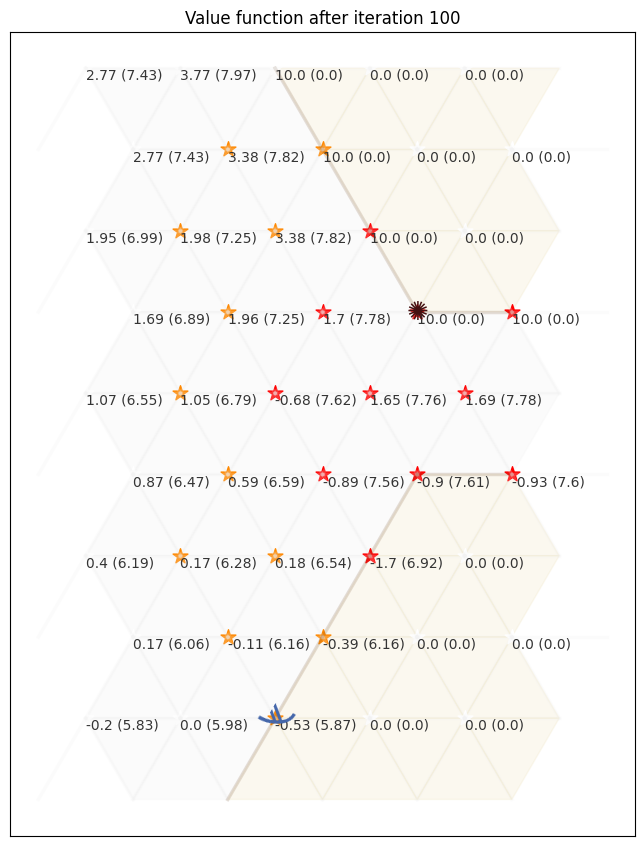

In [87]:
ccross = ContestedCrossing()
values = TabularValueFunction()
ValueIteration(ccross, values).value_iteration(max_iterations=100)
ccross.visualise_value_function(
    values, "Value function after iteration 100", mode=3, cell_size=1.25
)